# 数据读入模块

In [1]:
import pandas as pd


train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [2]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [3]:
train_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in test_data['judicial_reason']]


In [4]:
train_data['nan_num'] = (train_data == 0).astype(int).sum(axis=1)
test_data['nan_num'] = (test_data == 0).astype(int).sum(axis=1)


In [5]:
import pandas as pd
temp_df = pd.read_csv("./data/detail/df_loan1_b1.csv")


def chuli_loan(df, colname, ways):
    cust_id = list(set(df['cust_id']))
    res_df = pd.DataFrame({'cust_id': cust_id})
    temp_train = pd.read_csv('./data/df_train.csv')
    temp_test = pd.read_csv('./data/df_test.csv')

    ways_1 = []
    temp = list(temp_test.columns)
    global train_data, test_data

    for i in ways:
        if (colname+'_'+i) not in temp:
            ways_1.append(i)
            res_df[colname+'_'+i] = None
        else:
            print(colname+'_'+i+'已存在')
            train_data = pd.merge(train_data, temp_train[['cust_id', colname+'_'+i]], on="cust_id",
                                  how="left", suffixes=("", "_y"))
            test_data = pd.merge(test_data, temp_test[['cust_id', colname+'_'+i]], on="cust_id",
                                 how="left", suffixes=("", "_y"))
    ways = ways_1
    if len(ways) == 0:
        return res_df
    for i in cust_id:
        cust_df = df[df['cust_id'] == i]
        if 'mean' in ways:
            x = cust_df[colname].mean()
            res_df.loc[i, colname+'_mean'] = x
        if 'sum' in ways:
            x = cust_df[colname].sum()
            res_df.loc[i, colname+'_sum'] = x
        if 'count' in ways:
            x = cust_df[colname].count()
            res_df.loc[i, colname+'_count'] = x
    return res_df


for colname in ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']:
    df = chuli_loan(temp_df, colname, ('mean', 'sum', 'count'))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'date_3', ('count',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_10', ('mean',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_11', ('sum',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_12', ('sum',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))


loan1_1_mean已存在
loan1_1_sum已存在
loan1_1_count已存在
loan1_3_mean已存在
loan1_3_sum已存在
loan1_3_count已存在
loan1_7_mean已存在
loan1_7_sum已存在
loan1_7_count已存在
loan1_9_mean已存在
loan1_9_sum已存在
loan1_9_count已存在
date_3_count已存在
loan1_10_mean已存在
loan1_11_sum已存在
loan1_12_sum已存在


## 处理NAN

In [6]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [7]:
df_train = delnan(train_data)
df_test = delnan(test_data)


## 处理-99

In [8]:
df_train.replace(-99, -1, inplace=True)
df_test.replace(-99, -1, inplace=True)


In [9]:
df_train.to_csv('./data/df_train.csv')
df_test.to_csv('./data/df_test.csv')


## 主成分分析（效果不好）

In [10]:
# from sklearn.decomposition import PCA

# full_col_name = list(df_train.columns)
# pca_col=[i for i in full_col_name if "loan" in i]

# modelPCA=PCA(n_components=0.9)
# temp=modelPCA.fit_transform(df_train[pca_col])
# temp1=modelPCA.transform(df_test[pca_col])
# for i in range(temp.shape[1]):
#     df_train['loan_pca'+str(i)]=temp[:,i]
#     df_test['loan_pca'+str(i)]=temp1[:,i]


## 处理分类变量

In [11]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25", ]


## 转化为one-hot编码（不宜采用）

In [12]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """


' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [13]:
import pandas as pd
import numpy as np


def cal_woe(df, df_no_label, x_cols, y_col):
    for i in x_cols:
        x_set = pd.unique(df[i])
        for j in x_set:
            woe = np.mean(df[df[i] == j][y_col])
            df[i].replace(j, woe, inplace=True)
            df_no_label[i].replace(j, woe, inplace=True)
    return df, df_no_label


In [14]:
df_train, df_test = cal_woe(df_train, df_test, type_col, "label")


In [15]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col = [i for i in full_col_name if "judicial" in i]
loan_pca_col = [i for i in full_col_name if "loan_pca" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """


' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## rank化

In [16]:
def rank(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = np.argsort(df[i])
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# rank(c)


## 归一化

In [17]:
def norm(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.min(df[i]))/(np.max(df[i])-np.min(df[i]))
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
norm(c)


## 标准化

In [18]:
def stand(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.mean(df[i], axis=0))/np.std(df[i], axis=0)
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# stand(c)


## 设置哪些x作为模型自变量输入

In [19]:
x_col = basic_col+['is_judicial']+loan_col+['date_3_count']


In [20]:
# df_train.drop(columns=drop_col)


# 训练模型

## 超参数

In [21]:
N = 1000
num_round = 100
local_test_size = 300

max_depth = [3, 4, 5, 6, 7, 8]
eta = [0.1, 0.06]
colsample_bytree = [0.8, 0.7, 0.6]
scale_pos_weight = [1, 3, 6, 10, 20, 30]
test_size = [0.3, 0.2, 0.4, 0.5, 0.6, 0.7]
subsample = [0.8, 0.7, 0.6, 0.5, 0.4]
par_lambda = [1, 1.5, 2, 3]
alpha = [0, 0.2, 0.4, 0.6, 0.8]
min_child_weight = [1, 2, 3, 4, 5]
gamma = [0, 0.05, 0.1, 0.15, 0.2]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [22]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag = 0
important_x_seq = []

num_seq = list(range(len(df_train)))
np.random.shuffle(num_seq)

d_full=xgb.DMatrix(df_train[x_col],label=df_train['label'])

X_local_test = df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test = df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest = xgb.DMatrix(X_local_test, label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])

for i in range(N):

    #seed = 666
    test_size_this_round = random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        # 'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample': random.choice(subsample),
        'alpha': random.choice(alpha),
        'lambda': random.choice(par_lambda),
        'min_child_weight': random.choice(min_child_weight),
        'gamma': random.choice(gamma),
        # 'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        # "enable_enable_categorical":True,
    }

    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=5, verbose_eval=False)

    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])
    global_auc=float(bst.eval(d_full).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])

    temp_dict = {"test_auc": loss, "train_auc": train_loss,
                 'local_test_auc': local_test_loss, 'test_size': test_size_this_round,
                 'global_auc':global_auc}
    temp_dict.update(param)

    # info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag == 0:
        info_df = pd.DataFrame(temp_dict, index=[i])
        flag = 1
    else:
        info_df = pd.concat([info_df, pd.DataFrame(temp_dict, index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss

    if False:
        pic = xgb.plot_importance(bst, max_num_features=50)
        temp = pic.get_ymajorticklabels()
        important_x = [str(i).split("\'")[1] for i in temp]
        important_x.reverse()
        important_x_seq += important_x

    print(i+1, ":", loss, sep="")
    # print(param)
    # print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")


1:0.6566277372262773
2:0.6685847823063013
3:0.6644644325657895
4:0.664077458625331
5:0.6537272663586978
6:0.6752206881118952
7:0.49975233769886734
8:0.6654479163466167
9:0.6466188022181422
10:0.6911365944468774
11:0.7115600448933782
12:0.5921273614190687
13:0.6589076772334359
14:0.6563982827551018
15:0.6279925120442169
16:0.497815958582005
17:0.6611840378430609
18:0.5900524860280125
19:0.6324298260380037
20:0.681894227653759
21:0.6592378535979811
22:0.6552008860853687
23:0.6549010500346458
24:0.6619501072961373
25:0.6605315555379448
26:0.6439566529703221
27:0.6509460377875085
28:0.7367420677767982
29:0.6644361220371765
30:0.6692654879641724
31:0.6779932354236438
32:0.6444890302809595
33:0.6583715372610223
34:0.6446926164303344
35:0.6155794902514062
36:0.6836710850980751
37:0.6361543818682726
38:0.6552894417475729
39:0.6698994718269604
40:0.6582247937224731
41:0.6580429420601672
42:0.5644456367727955
43:0.6368293187339638
44:0.6641298886458051
45:0.6882723858324388
46:0.6116132193494579

In [23]:
info_df


,test_auc,train_auc,local_test_auc,test_size,global_auc,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,gamma,tree_method,gpu_id
0,0.656628,0.996536,0.893408,0.4,0.874402,8,0.06,0.8,binary:logistic,6,auc,0.7,0.0,1.5,5,0.05,gpu_hist,0
1,0.668585,0.884312,0.871575,0.3,0.822762,8,0.10,0.7,binary:logistic,1,auc,0.7,0.8,3.0,1,0.10,gpu_hist,0
2,0.664464,0.752203,0.783818,0.3,0.725584,3,0.10,0.6,binary:logistic,10,auc,0.4,0.4,1.5,4,0.10,gpu_hist,0
3,0.664077,0.839261,0.803938,0.5,0.753991,4,0.06,0.8,binary:logistic,30,auc,0.5,0.2,2.0,1,0.20,gpu_hist,0
4,0.653727,0.979715,0.810788,0.4,0.847251,7,0.10,0.6,binary:logistic,6,auc,0.5,0.4,3.0,3,0.15,gpu_hist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.650594,0.975858,0.722603,0.4,0.843444,7,0.06,0.7,binary:logistic,10,auc,0.8,0.6,1.5,2,0.15,gpu_hist,0
996,0.639714,0.743119,0.736515,0.3,0.712035,3,0.10,0.8,binary:logistic,3,auc,0.7,0.4,3.0,1,0.00,gpu_hist,0
997,0.656051,0.862450,0.905394,0.2,0.817679,7,0.10,0.8,binary:logistic,3,auc,0.6,0.6,1.5,1,0.05,gpu_hist,0
998,0.670480,0.992862,0.720034,0.4,0.858787,7,0.10,0.7,binary:logistic,20,auc,0.7,0.4,3.0,1,0.10,gpu_hist,0


In [24]:
info_df.to_csv("info.csv", encoding="utf-8", index=False)


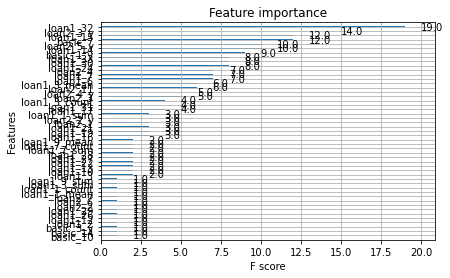

In [25]:
pic = xgb.plot_importance(best_bst, max_num_features=50)
temp = pic.get_ymajorticklabels()
important_x = [str(i).split("\'")[1] for i in temp]
important_x.reverse()


In [26]:
important_x


['loan1_32',
 'loan2_3_y',
 'loan1_15',
 'basic_7',
 'loan2_5_y',
 'loan1_14',
 'basic_1_y',
 'loan1_33',
 'loan1_30',
 'loan1_24',
 'loan2_4',
 'loan1_7',
 'loan1_6',
 'loan1_3_mean',
 'loan2_11',
 'loan2_4_y',
 'loan2_3',
 'loan1_3_count',
 'loan1_31',
 'loan1_17',
 'loan1_1_sum',
 'loan2_2_y',
 'loan2_1',
 'loan1_21',
 'loan1_19',
 'loan1_16',
 'loan1_9_mean',
 'loan1_7_count',
 'loan1_7_sum',
 'loan1_28',
 'loan1_27',
 'loan1_22',
 'loan1_13',
 'loan1_10',
 'loan1_3',
 'loan1_9_sum',
 'loan1_3_sum',
 'loan1_1_count',
 'loan1_1_mean',
 'loan2_7',
 'loan2_6',
 'loan2_2',
 'loan1_29',
 'loan1_26',
 'loan1_12',
 'loan1_2',
 'basic_3_y',
 'basic_14',
 'basic_10']

In [27]:
# pd.value_counts(important_x_seq)


* basic_7:年龄
* 

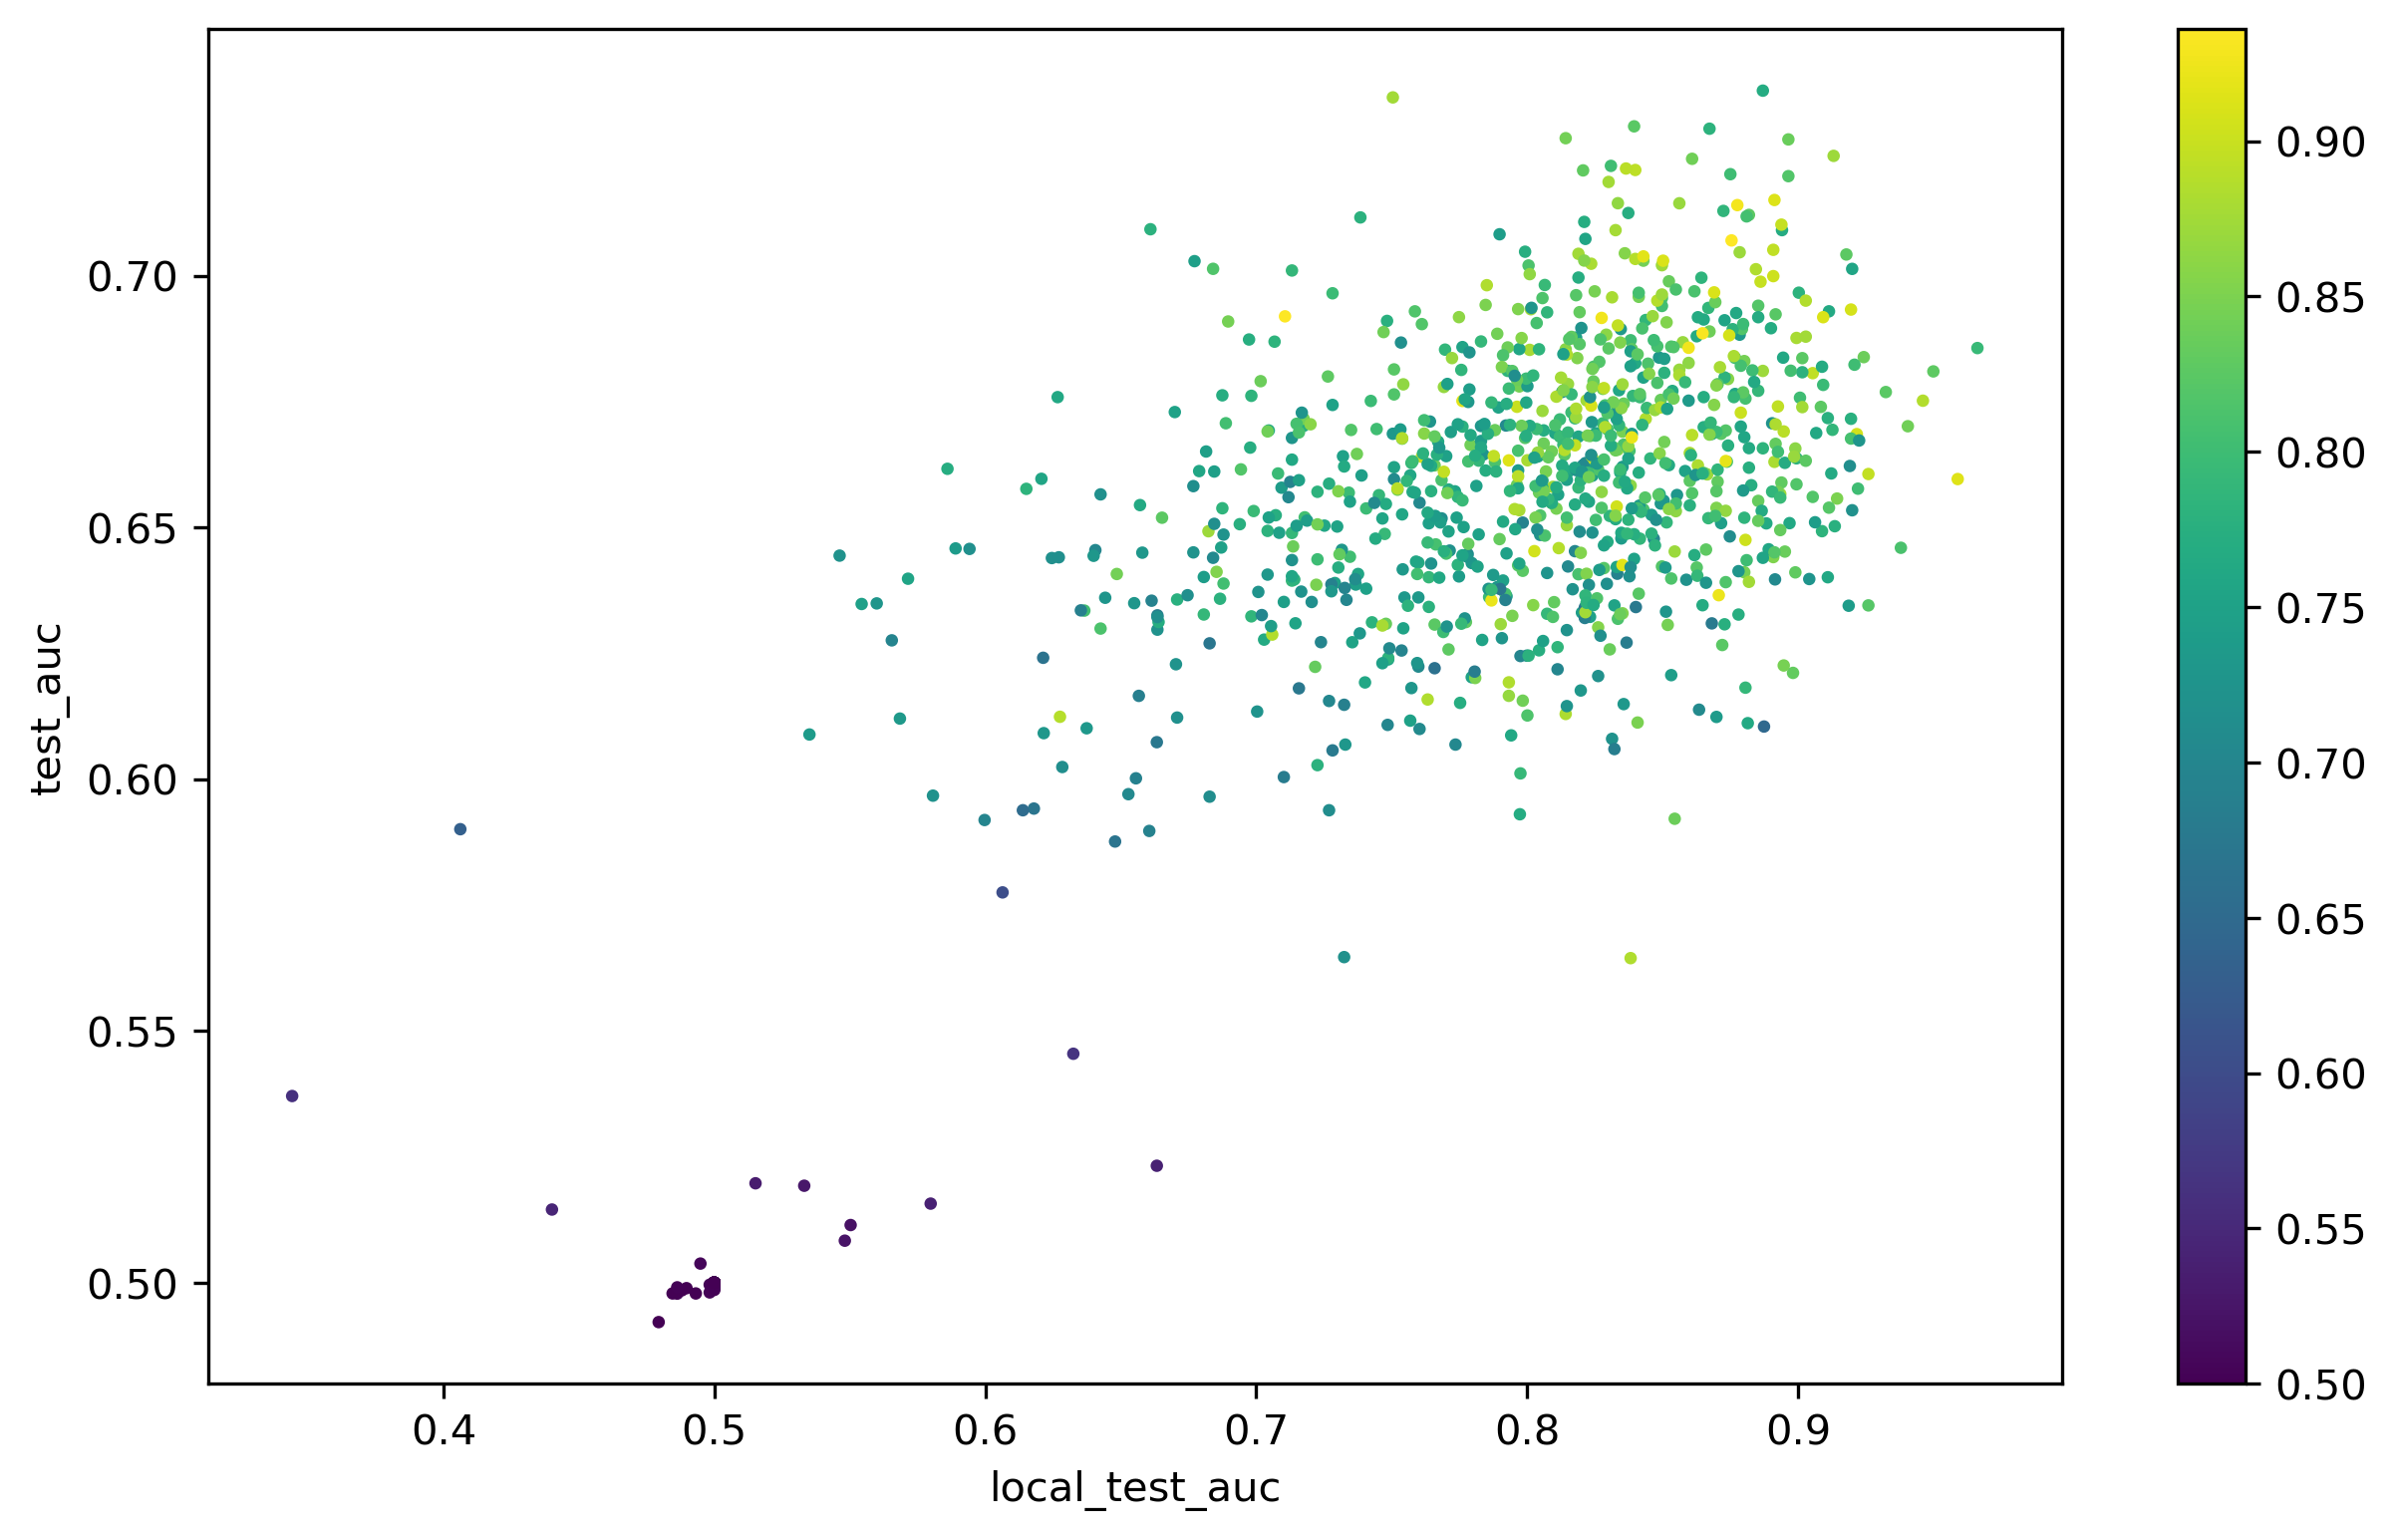

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6),dpi=300)
plt.scatter(info_df['local_test_auc'], info_df['test_auc'],c=info_df['global_auc'],s=4)
plt.xlabel('local_test_auc')
plt.ylabel('test_auc')
plt.colorbar()

# 输出模块

In [31]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['global_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        # 算数平均
        # temp = np.mean(list_temp, axis=0)
        # 几何平均(better)
        temp = np.exp(np.mean(np.log(list_temp), axis=0))
        temp_auc = roc_auc_score(Y_local_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i+1
else:
    n = 100
    n = min(N, n)

res_num = res_num[0:n]

#final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
final_pred_label = np.exp(
    np.mean(np.log([pred_labels[i] for i in res_num]), axis=0))
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [
      list(info_df['local_test_auc'])[i] for i in res_num], sep="")
print("平均之后local_test_AUC为", max_auc, sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


0 0.7106164383561644
1 0.8107876712328766
2 0.8441780821917808
3 0.8527397260273972
4 0.8523116438356164
5 0.8595890410958903
6 0.8642979452054794
7 0.8647260273972603
8 0.8634417808219178
9 0.8698630136986301
10 0.872859589041096
11 0.8754280821917807
12 0.8698630136986301
13 0.8827054794520548
14 0.8809931506849316
15 0.8865582191780822
16 0.8874143835616438
17 0.8899828767123288
18 0.8908390410958905
19 0.8925513698630136
20 0.8934075342465753
21 0.894263698630137
22 0.8925513698630136
23 0.8942636986301369
24 0.889126712328767
25 0.8882705479452054
26 0.889126712328767
27 0.8912671232876713
28 0.8934075342465754
29 0.8921232876712328
30 0.8938356164383562
31 0.894263698630137
32 0.8946917808219179
33 0.8929794520547946
34 0.8946917808219178
35 0.8934075342465753
36 0.8976883561643836
37 0.8964041095890412
38 0.8981164383561644
39 0.898972602739726
40 0.898972602739726
41 0.898972602739726
42 0.8998287671232876
43 0.8994006849315068
44 0.8985445205479451
45 0.8985445205479451
46 0.8

# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用